In [32]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pdb
from scipy.io import loadmat
from sklearn.preprocessing import binarize, minmax_scale
from scipy import optimize
from math import pi, log2
import warnings
from utils import *
from DataFile import DataFile

In [3]:
mat_files = [m for m in os.listdir("data") if m.endswith('mat')]
session_list = pd.read_excel('data/CacheRetrieveSessionList.xlsx', index_col=0)
fps = 20
cmap = cm.get_cmap('viridis')

# Identifying place fields

In [4]:
def get_spatial_fr(f, neurs):
    fr = f.fr[:,neurs]
    thetas = f.theta
    num_bins = 100
    boundaries = np.linspace(0, 2*pi, num_bins, endpoint=True)
    thetas = np.digitize(thetas, boundaries)
    spatial_fr = np.zeros((neurs.size, num_bins))
    for idx, theta in enumerate(np.unique(thetas)):
        bin_fr = np.mean(fr[thetas == theta,:], axis=0)
        spatial_fr[:,idx] = bin_fr
    return spatial_fr

In [5]:
def find_field(f, neurs):
    fr = f.fr
    wedges = f.wedges
    fr = fr[:, neurs]
    fr_mean = np.mean(fr, axis=0)
    fr_std = np.mean(fr, axis=0)
    wedge_labels = np.unique(wedges)
    fields = np.zeros((neurs.size, wedge_labels.size - 1))
    for wedge in wedge_labels:
        if wedge == 17: continue
        wedge_frames = np.argwhere(wedges == wedge).squeeze()
        wedge_fr = fr[wedge_frames,:]
        fields[:, int(wedge) - 1] = np.mean(wedge_fr, axis=0)
    threshold = fr_mean + 1*fr_std
    threshold = np.tile(threshold, (fields.shape[1], 1)).T
    sig_fields_fr = fields.copy()
    sig_fields_fr[fields < threshold] = 0
    sig_fields = np.argmax(sig_fields_fr, axis=1) + 1
    sig_fields[np.sum(sig_fields_fr, axis=1)==0] = -1
    return sig_fields

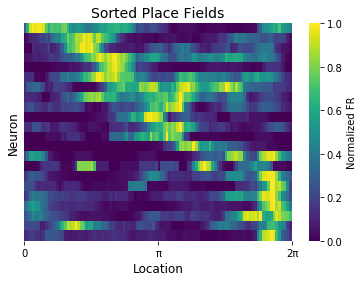

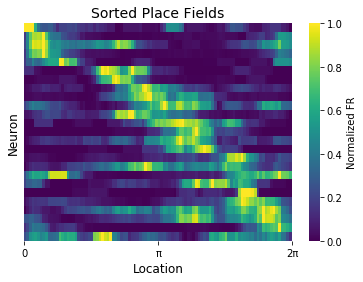

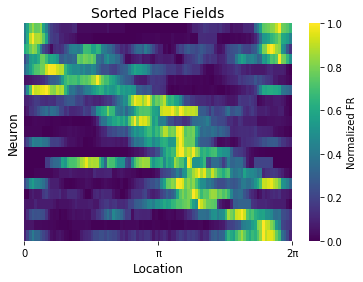

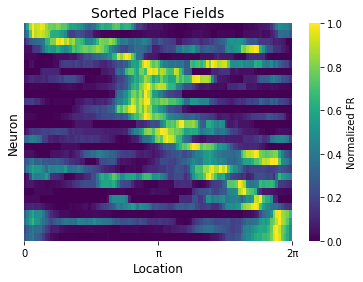

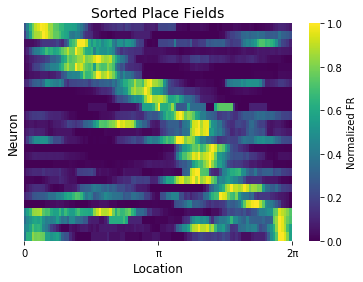

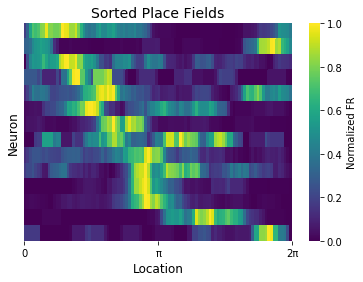

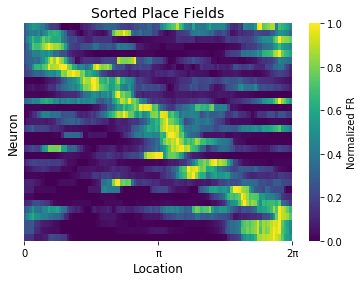

In [42]:
with open("spatial.p", "rb") as f:
    spatial_infos = pickle.load(f)
for mat_file in mat_files:
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    spatial_info = spatial_infos[mat_file]
    sig_neurs = np.argwhere(spatial_info > 0).squeeze()
    sig_fields = find_field(f, sig_neurs)
    spatial_fr = get_spatial_fr(f, sig_neurs)
    spatial_fr = spatial_fr[sig_fields != -1]
    spatial_fr = get_fr(spatial_fr.T, 6).T
    sig_fields = sig_fields[sig_fields != -1]
    sorted_spatial_fr = spatial_fr[np.argsort(sig_fields),:]
    sorted_spatial_fr = minmax_scale(sorted_spatial_fr.T).T
    sns.heatmap(sorted_spatial_fr, cmap="viridis",cbar_kws={'label': 'Normalized FR'})
    num_bins = sorted_spatial_fr.shape[1]
    plt.yticks([])
    plt.xticks(np.linspace(0,num_bins,3), ["0", "\u03C0", "2\u03C0"], rotation=0)
    plt.ylabel("Neuron", fontsize=12)
    plt.xlabel("Location", fontsize=12)
    plt.title("Sorted Place Fields", fontsize=14)
    plt.show()

In [8]:
np.median(sorted_spatial_fr)

0.003484193250288246

# Conjunctive Map

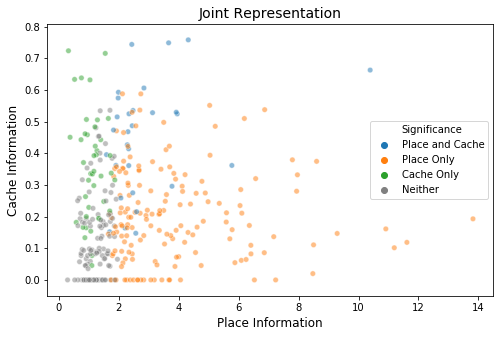

In [62]:
spatial_f = "spatial-all.p"
ep_f = "ci-visit-shuff-all-60.p"
with open(spatial_f, "rb") as f:
    place_results = pickle.load(f)
with open(ep_f, "rb") as f:
    ep_results = pickle.load(f)
place_info = []
ep_info = []
sigs = []
for mat_file in mat_files:
    _pl_mi = place_results[mat_file]["Matrix"]
    _ep_mi = ep_results[mat_file]["Matrix"]
    pl_sig = place_results[mat_file]["Significants"]
    ep_sig = ep_results[mat_file]["Significants"]
    for neur in range(_pl_mi.size):
        if pl_sig[neur] and ep_sig[neur]:
            sigs.append("Place and Cache")
        elif pl_sig[neur]:
            sigs.append("Place Only")
        elif ep_sig[neur]:
            sigs.append("Cache Only")
        else:
            sigs.append("Neither")
        place_info.append(_pl_mi[neur])
        ep_info.append(np.mean(_ep_mi[:,neur]))
df = pd.DataFrame({
    "Place": place_info, "Ep": ep_info, "Significance": sigs
    })
fig, ax = plt.subplots(figsize=(8,5))
palette = sns.color_palette()
color_dict = {
    "Place and Cache": palette[0], "Place Only": palette[1],
    "Cache Only": palette[2], "Neither": "grey"
    }
sns.scatterplot(
    x="Place", y="Ep", hue="Significance", alpha=0.5,
    data=df, ax=ax, s=30, palette=color_dict,
     hue_order = ["Place and Cache", "Place Only", "Cache Only", "Neither"]
    )
plt.xlabel("Place Information", fontsize=12)
plt.ylabel("Cache Information", fontsize=12)
plt.title("Joint Representation", fontsize=14)
plt.savefig("conj.png")
plt.show()

(22, 56)

# Population Activity during caching/retrieval

In [35]:
[c.size for c in cache_hops_fr]

[401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401]

ExtractedWithXY_Cleaned184713_09102019.mat


/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


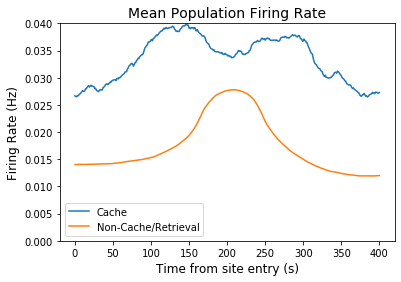

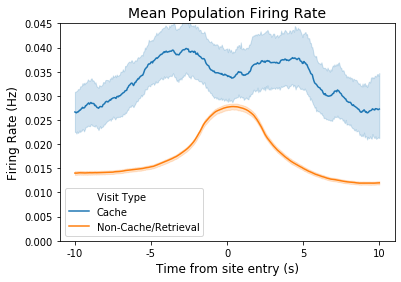

In [66]:
window = 10*fps
all_cache_hops_fr = []
all_noncache_hops_fr = []
pd_idx = []
pd_label = []
pd_fr = []
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    fr = f.fr 
    fr = get_fr(f.spikes, window=int(4*fps))
    cache_idxs = np.zeros((f.cache_sites.size, f.num_neurs))
    cache_hops_fr, noncache_hops_fr, noncache_hops_wedges = \
        f.get_hopcentered_fr(window, fr=fr, nanpad=True)
    cache_hops_fr = [
        np.nanmean(c, axis=1) for idx, c in enumerate(cache_hops_fr) \
        if f.was_cache[idx]
        ]
    noncache_hops_fr = [np.nanmean(nc, axis=1) for nc in noncache_hops_fr]
    all_cache_hops_fr.extend(cache_hops_fr)
    all_noncache_hops_fr.extend(noncache_hops_fr)
    for cache_hop_fr in cache_hops_fr:
        for idx, fr in enumerate(cache_hop_fr):
            if np.isnan(fr):
                continue
            pd_idx.append(idx)
            pd_label.append("Cache")
            pd_fr.append(fr)
    for noncache_hop_fr in noncache_hops_fr:
        for idx, fr in enumerate(noncache_hop_fr):
            if np.isnan(fr):
                continue
            pd_idx.append(idx)
            pd_label.append("Non-Cache/Retrieval")
            pd_fr.append(fr)
plt.figure()
plt.plot(np.nanmean(all_cache_hops_fr, axis=0), label="Cache")
plt.plot(np.nanmean(all_noncache_hops_fr, axis=0), label="Non-Cache/Retrieval")
plt.title("Mean Population Firing Rate", fontsize=14)
plt.ylim(0, 0.04)
plt.xlabel("Time from site entry (s)", fontsize=12)
plt.ylabel("Firing Rate (Hz)", fontsize=12)
plt.legend()
plt.show()

df = pd.DataFrame({
    "Index": pd_idx, "Visit Type": pd_label, "Rate": pd_fr
    })
sns.lineplot(x="Index", y="Rate", hue="Visit Type", data=df)
plt.title("Mean Population Firing Rate", fontsize=14)
plt.ylim(0, 0.045)
plt.xlabel("Time from site entry (s)", fontsize=12)
plt.ylabel("Firing Rate (Hz)", fontsize=12)
plt.xticks(
    [0, window/2, window, 3*window/2, 2*window],
    [-window//fps, -window//(2*fps), 0, window//(2*fps), window//fps]
    )
plt.savefig("cnc.png")
plt.show()

In [65]:
len(all_cache_hops_fr)

59

ExtractedWithXY_Cleaned184713_09102019.mat


/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


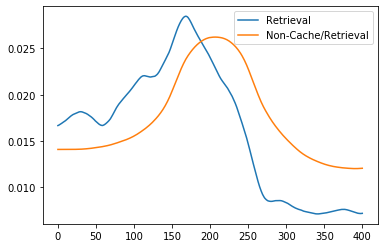

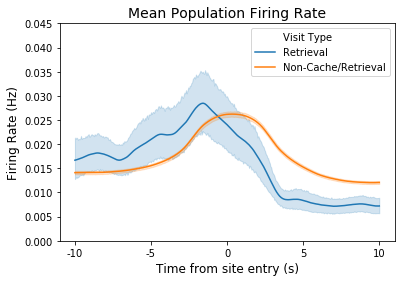

In [75]:
window = 20*10
all_cache_hops_fr = []
all_noncache_hops_fr = []
pd_idx = []
pd_label = []
pd_fr = []
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    fr = f.fr 
    fr = get_fr(fr, window=5*fps)
    cache_idxs = np.zeros((f.cache_sites.size, f.num_neurs))
    cache_hops_fr, noncache_hops_fr, noncache_hops_wedges = \
        f.get_hopcentered_fr(window, nanpad=True, fr=fr)
    cache_hops_fr = [
        np.nanmean(c, axis=1) for idx, c in enumerate(cache_hops_fr) \
        if f.was_retrieval[idx]
        ]
    noncache_hops_fr = [np.nanmean(nc, axis=1) for nc in noncache_hops_fr]
    all_cache_hops_fr.extend(cache_hops_fr)
    all_noncache_hops_fr.extend(noncache_hops_fr)
    for cache_hop_fr in cache_hops_fr:
        for idx, fr in enumerate(cache_hop_fr):
            if np.isnan(fr):
                continue
            pd_idx.append(idx)
            pd_label.append("Retrieval")
            pd_fr.append(fr)
    for noncache_hop_fr in noncache_hops_fr:
        for idx, fr in enumerate(noncache_hop_fr):
            if np.isnan(fr):
                continue
            pd_idx.append(idx)
            pd_label.append("Non-Cache/Retrieval")
            pd_fr.append(fr)
plt.figure()
plt.plot(np.nanmean(all_cache_hops_fr, axis=0), label="Retrieval")
plt.plot(np.nanmean(all_noncache_hops_fr, axis=0), label="Non-Cache/Retrieval")
plt.legend()
plt.show()

df = pd.DataFrame({
    "Index": pd_idx, "Visit Type": pd_label, "Rate": pd_fr
    })
sns.lineplot(x="Index", y="Rate", hue="Visit Type", data=df)
plt.title("Mean Population Firing Rate", fontsize=14)
plt.ylim(0, 0.045)
plt.xlabel("Time from site entry (s)", fontsize=12)
plt.ylabel("Firing Rate (Hz)", fontsize=12)
plt.xticks(
    [0, window/2, window, 3*window/2, 2*window],
    [-window//fps, -window//(2*fps), 0, window//(2*fps), window//fps]
    )
plt.savefig("rnc.png")
plt.show()

# Activity during episodes

In [73]:
episode_grid_file = "mi-hopvis-circvisshuff-60.p"
#episode_grid_file = "ci-visit-shuff-60.p"
with open(episode_grid_file, "rb") as f:
    episode_info_mat = pickle.load(f)

In [19]:
def dist(A, b):
    adotb = np.dot(A, b)
    asumsq = np.sum(np.square(A), axis=1)
    bsumsq = np.sum(np.square(b))
    dist = adotb/(asumsq + bsumsq - adotb)
#     if np.sum(np.isnan(dist)) > 0:
#         import pdb; pdb.set_trace()
    return dist

In [20]:
window = 40
cache_popln_fr = {}
noncache_popln_fr = {}
for mat_file in mat_files:
    cache_popln_fr[mat_file] = []
    noncache_popln_fr[mat_file] = []
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    cache_idxs = np.zeros((f.cache_sites.size, f.num_neurs))
    cache_hops_frames, noncache_hops_frames, noncache_hops_wedges = \
        f.get_hopcentered_frames(window)
    fr = get_fr(f.fr, int(fps*0.1))
    fr = get_fr(f.spikes, int(fps*0.25))
    fr = get_fr(f.fr, int(fps*0.15))
#     shuff_fr = fr.flatten()
#     np.random.shuffle(shuff_fr)
#     shuff_fr = shuff_fr.reshape(fr.shape)
#     fr = shuff_fr
#     for idx in range(f.cache_sites.size):
#         cache_frames = np.arange(f.cache_enters[idx], f.cache_exits[idx]).astype(int)
#         pattern = np.mean(fr[cache_frames,:], axis=0)
#         cache_popln_fr[mat_file].append(pattern)
#     noncache_frames = [
#         np.arange(enter, exit).astype(int) for \
#         enter, exit in zip(f.noncache_enters, f.noncache_exits)
#         ]
#     for idx in range(len(noncache_frames)):
#         hop_frames = noncache_frames[idx]
#         hop_wedge = f.noncache_wedges[idx]
#         pattern = np.mean(fr[hop_frames,:], axis=0)
#         noncache_popln_fr[mat_file].append(pattern)   
    for idx in range(f.cache_sites.size):
        cache_site = f.cache_sites[idx]
        cache_frames = cache_hops_frames[idx]
        pattern = fr[cache_frames,:]
        cache_popln_fr[mat_file].append(pattern)
    for idx in range(len(noncache_hops_frames)):
        hop_frames = noncache_hops_frames[idx]
        hop_wedge = noncache_hops_wedges[idx]
        pattern = fr[hop_frames,:]
        noncache_popln_fr[mat_file].append(pattern)

ExtractedWithXY_Cleaned184713_09102019.mat


/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


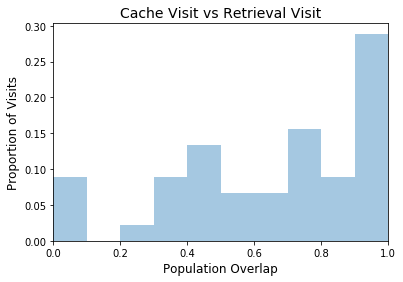

45


In [25]:
# Cache v retrieval of same site
corr = []
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    cache_hops_frames, noncache_hops_frames, noncache_hops_wedges = \
        f.get_hopcentered_frames(window)
    for i in range(f.cache_sites.size):
        if f.was_retrieval[i]: continue
        cache_site_i = f.cache_sites[i]
        cache_pattern_mat = cache_popln_fr[mat_file][i] # (frames, neurs)
        for j in range(i+1, f.cache_sites.size):
            if f.was_cache[j]: continue
            if f.cache_sites[j] != cache_site_i: continue
            retriev_pattern_mat = cache_popln_fr[mat_file][j]
            overlaps = []
            for retriev_pattern in retriev_pattern_mat: # (neurs)
                overlap = dist(cache_pattern_mat, retriev_pattern)
                overlaps.append(np.nanmax(overlap))
            corr.append(np.nanmax(overlaps))
            break
plt.figure()
#sns.distplot(corr, bins=10)
plt.hist(corr, bins=10, alpha=0.4, weights=np.ones(len(corr)) / len(corr))
plt.title("Cache Visit vs Retrieval Visit", fontsize=14)
plt.ylabel("Proportion of Visits", fontsize=12)
plt.xlabel("Population Overlap", fontsize=12)
plt.xlim((0,1))
plt.show()
print(len(corr))

ExtractedWithXY_Cleaned184713_09102019.mat


/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


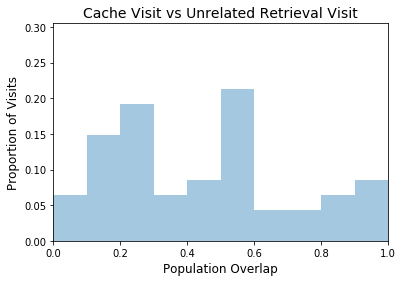

47


In [29]:
# Cache v retrieval of same site
corr = []
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    cache_hops_frames, noncache_hops_frames, noncache_hops_wedges = \
        f.get_hopcentered_frames(window)
    for i in range(f.cache_sites.size):
        if f.was_retrieval[i]: continue
        cache_site_i = f.cache_sites[i]
        cache_pattern_mat = cache_popln_fr[mat_file][i] # (frames, neurs)
        for j in range(i+1, f.cache_sites.size):
            if f.was_cache[j]: continue
            if f.cache_sites[j] == cache_site_i: continue
            retriev_pattern_mat = cache_popln_fr[mat_file][j]
            overlaps = []
            for retriev_pattern in retriev_pattern_mat: # (neurs)
                overlap = dist(cache_pattern_mat, retriev_pattern)
                overlaps.append(np.nanmax(overlap))
            corr.append(np.nanmax(overlaps))
            break
plt.figure()
#sns.distplot(corr, bins=10)
plt.hist(corr, bins=10, alpha=0.4, weights=np.ones(len(corr)) / len(corr))
plt.title("Cache Visit vs Unrelated Retrieval Visit", fontsize=14)
plt.ylabel("Proportion of Visits", fontsize=12)
plt.xlabel("Population Overlap", fontsize=12)
plt.xlim((0,1))
plt.ylim((0,0.305))
plt.show()
print(len(corr))

ExtractedWithXY_Cleaned184713_09102019.mat


/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


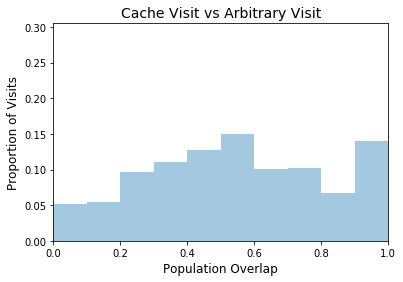

2555


In [31]:
# Cache v arbitrary visit
corr = []
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    cache_hops_frames, noncache_hops_frames, noncache_hops_wedges = \
        f.get_hopcentered_frames(window)
    for i in range(f.cache_sites.size):
        if f.was_retrieval[i]: continue
        cache_site_i = f.cache_sites[i]
        cache_pattern_mat = cache_popln_fr[mat_file][i]
        for j in range(len(noncache_hops_frames)):
            if noncache_hops_wedges[j] != cache_site_i: continue
            noncache_pattern_mat = noncache_popln_fr[mat_file][j]
            overlaps = []
            for noncache_pattern in noncache_pattern_mat: # (neurs)
                overlap = dist(cache_pattern_mat, noncache_pattern)
                overlaps.append(np.nanmax(overlap))
            corr.append(np.nanmax(overlaps))
plt.figure()
#sns.distplot(corr)
plt.hist(corr, bins=10, alpha=0.4, weights=np.ones(len(corr)) / len(corr))
plt.xlim((0,1))
plt.ylim((0,0.305))
plt.title("Cache Visit vs Arbitrary Visit", fontsize=14)
plt.ylabel("Proportion of Visits", fontsize=12)
plt.xlabel("Population Overlap", fontsize=12)
plt.show()
print(len(corr))

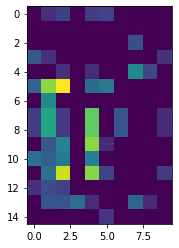

In [67]:
plt.imshow(np.array(cache_popln_fr[mat_files[0]]))

In [70]:
f = h5py.File("data/" + mat_files[0], 'r')
f = DataFile(f)
f.cache_sites

array([ 5.,  3.,  3.,  1.,  1., 15., 15., 13., 13., 11., 11.,  9.,  9.,
        8.,  8.])